In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [106]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [56]:
# Find the most recent date in the data set.
from datetime import datetime, timedelta
# Descending order by date.  Then select first (most recent) value
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
# Query returned a tuple.  Need to convert to string for strptime function
for row in recent:
    recent_date = row
print(recent_date)

2017-08-23


<Axes: xlabel='Inches', ylabel='Date'>

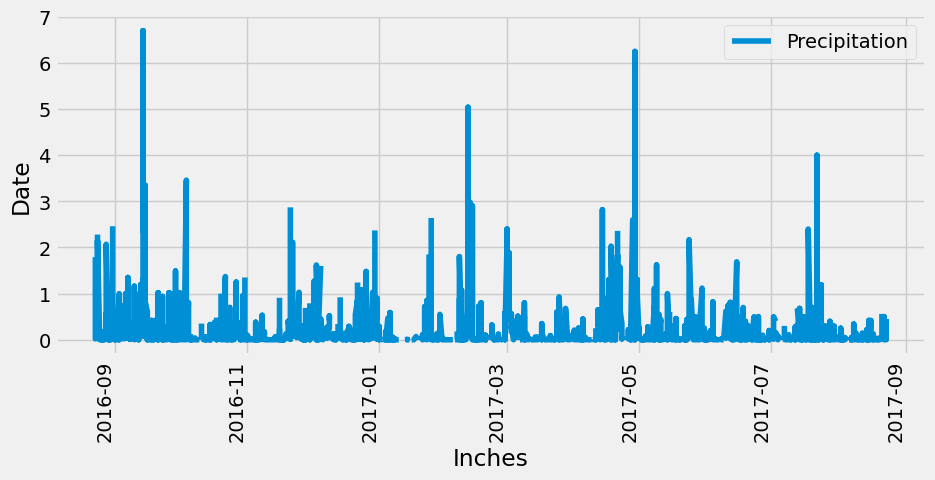

In [105]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_format = '%Y-%m-%d'      # Set date format
start_date = dt.datetime.strptime(recent_date, date_format).date()   # Convert string to datetime date
year_ago = start_date - dt.timedelta(days=365)   # Calculate date one year ago

# Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_prcp_df = pd.DataFrame(date_prcp)
date_prcp_df["date"] = pd.to_datetime(date_prcp_df["date"])  # Convert date from string to datetime
date_prcp_df = date_prcp_df.rename(columns={"date":"Date", "prcp":"Precipitation"})  # Change column names

# Sort the dataframe by date
date_prcp_df.sort_values(by=['Date'])   
date_prcp_df.dropna(subset=["Precipitation"])  # Remove NAs

# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df.plot(x="Date", y="Precipitation", xlabel="Inches", ylabel="Date", rot=90, figsize=(10,5))



In [120]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prcp_df["Precipitation"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [159]:
# Design a query to calculate the total number of stations in the dataset
session.query(measurement.station).group_by(measurement.station).count()

9

In [186]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station)).all()
station_count = sorted(station_count, key=lambda count: count[1], reverse=True)
print(*station_count, sep="\n")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [212]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active = station_count[0][0]
active_query = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
    .filter(measurement.station==active)
print(*active_query)

(54.0, 85.0, 71.66378066378067)


<Axes: ylabel='Frequency'>

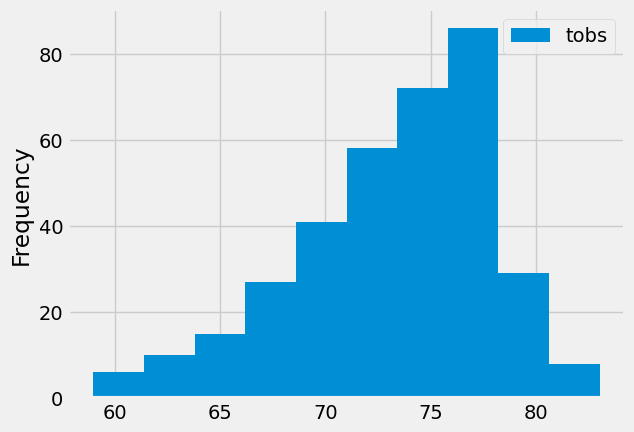

In [216]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temps = session.query(measurement.tobs).filter(measurement.station==active, measurement.date>=year_ago)
year_temps_df = pd.DataFrame(year_temps)
year_temps_df.plot(kind="hist")

# Close Session

In [217]:
# Close Session
session.close()